In [1]:
import sys
import pandas as pd
import numpy as np
import cudf
import cupy
from rdkit import Chem
from rdkit.Chem import PandasTools 

sys.path.insert(0, '/workspace/cddd')
sys.path.insert(0, '/workspace')
from nvidia.cheminformatics.fingerprint import Embeddings

## Settings

The trained model from the [CDDD](https://github.com/jrwnter/cddd) github repo is used. Here is how the code and model are setup inside of the container.

```
cd /workspace
git clone https://github.com/jrwnter/cddd.git
cd /workspace/cddd
/opt/conda/envs/cuchem/bin/pip install -e .
bash ./download_default_model.sh
```

After running this, double check that the model weights are present.

In [2]:
model_dir = '/workspace/cddd/default_model'
! ls {model_dir}

__init__.py    eval_reconstruct.csv	       model.ckpt.index
checkpoint     hparams.json		       model.ckpt.meta
eval_qsar.csv  model.ckpt.data-00000-of-00001


# Example 1: Aspirin --> Ibuprofen

## Input Data

The Embeddings class takes the 'transformed_smiles' column of a dataframe -- this is a carry-over from the CDDD library, but future classes should probably just take a single or list of SMILES strings.

This example uses the SMILES strings for [aspirin](https://pubchem.ncbi.nlm.nih.gov/compound/Aspirin) and [ibprofen](https://pubchem.ncbi.nlm.nih.gov/compound/Ibuprofen).

,name,transformed_smiles,transformed_molecule
0,aspirin,CC(=O)OC1=CC=CC=C1C(=O)O,
1,ibuprofen,CC(C)CC1=CC=C(C=C1)C(C)C(=O)O,

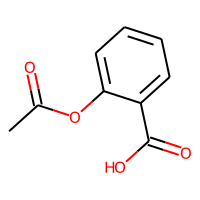
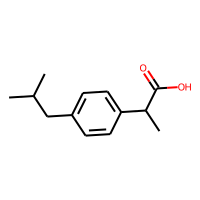

In [3]:
data = pd.DataFrame({'name': ['aspirin', 'ibuprofen'], 
                     'transformed_smiles': ['CC(=O)OC1=CC=CC=C1C(=O)O', 'CC(C)CC1=CC=C(C=C1)C(C)C(=O)O']})

PandasTools.AddMoleculeColumnToFrame(data, smilesCol='transformed_smiles', molCol='transformed_molecule')
data

## Get Model Embeddings for SMILES Strings

The model produces a 512-dimensional embedding for each of the SMILES strings.

In [5]:
cddd_embeddings = Embeddings(model_dir=model_dir)
embeddings = cddd_embeddings.transform(data)
print(embeddings.shape, type(embeddings))

INFO:tensorflow:Restoring parameters from /workspace/cddd/default_model/model.ckpt
(2, 512) <class 'numpy.ndarray'>


In [6]:
embeddings = np.asarray(embeddings)
embeddings

array([[ 0.49894014, -0.27814415, -0.81276685, ..., -0.31583226,
         0.54479676,  0.42476174],
       [-0.8373209 , -0.39210698, -0.04251679, ...,  0.6017364 ,
         0.6691654 , -0.4148546 ]], dtype=float32)

For good measure, let's see how the original two embeddings transform back to strings and images. Note that the aspirin string is different than starting -- it results in the sample molecule, but the hydrogen has been removed from the carboxyl group.

INFO:tensorflow:Restoring parameters from /workspace/cddd/default_model/model.ckpt


,name,transformed_smiles,transformed_molecule,regenerated_smiles,regenerated_molecule
0,aspirin,CC(=O)OC1=CC=CC=C1C(=O)O,,CC(=O)Oc1ccccc1C(=O)[O-],
1,ibuprofen,CC(C)CC1=CC=C(C=C1)C(C)C(=O)O,,CC(C)CC1=CC=C(C=C1)C(C)C(=O)O,

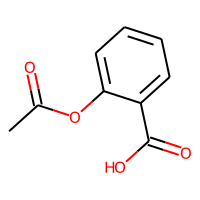
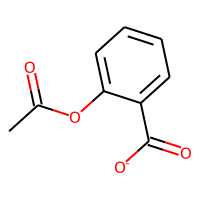
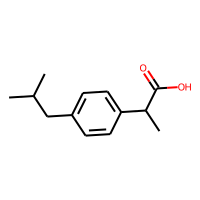
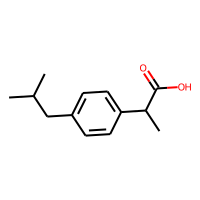

In [8]:
data['regenerated_smiles'] = cddd_embeddings.inverse_transform(embeddings)
PandasTools.AddMoleculeColumnToFrame(data, smilesCol='regenerated_smiles', molCol='regenerated_molecule')
data

## Interpolate Between Points

This is a simple linear interpolation between all the elements of the 512-dimensional embeddings. More exotic methods can also be implemented, such as using spherical coordinates, if desired.

In [9]:
num_points = 10

def linear_interpolate_points(embedding, num_points):
    return np.linspace(embedding[0], embedding[1], num_points+2)[1:-1]

interp_embeddings = np.apply_along_axis(linear_interpolate_points, axis=0, arr=embeddings, num_points=num_points)
assert interp_embeddings.shape == (num_points, embeddings.shape[1])
interp_embeddings

array([[ 0.37746186, -0.28850441, -0.74274412, ..., -0.23241692,
         0.556103  ,  0.34843299],
       [ 0.25598358, -0.29886467, -0.67272138, ..., -0.14900159,
         0.56740924,  0.27210423],
       [ 0.1345053 , -0.30922492, -0.60269865, ..., -0.06558625,
         0.57871548,  0.19577547],
       ...,
       [-0.47288609, -0.36102621, -0.25258499, ...,  0.35149042,
         0.63524666, -0.18586831],
       [-0.59436437, -0.37138647, -0.18256226, ...,  0.43490576,
         0.6465529 , -0.26219707],
       [-0.71584265, -0.38174672, -0.11253952, ...,  0.51832109,
         0.65785914, -0.33852583]])

INFO:tensorflow:Restoring parameters from /workspace/cddd/default_model/model.ckpt


,interpolated_smiles,interpolated_molecule
0,CC(=O)Oc1ccccc1C(=O)O,
1,CC(=O)Oc1ccccc1C(=O)O,
2,CC(=O)Oc1ccccc1C(=O)O,
3,CC(=O)Oc1ccccc1C(=O)O,
4,CC(=O)Oc1ccccc1C(C)C(=O)O,
5,CC(C)Cc1ccccc1C(=O)OC=O,
6,CC(C)Cc1ccc(C(=O)O)c(C=O)c1,
7,CC(C)Cc1ccc(C(=O)O)c(C=O)c1,
8,CC(C)CC1=CC=C(C(=O)O)C(C)C=C1,
9,CC(C)CC1=CC=C(C=C1)C(C)C(=O)O,

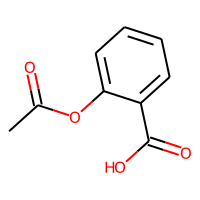
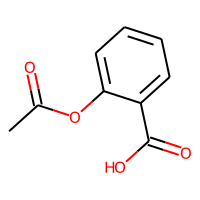
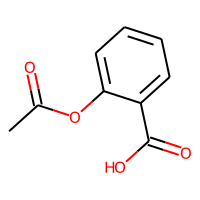
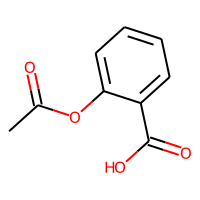
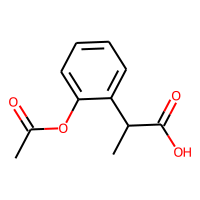
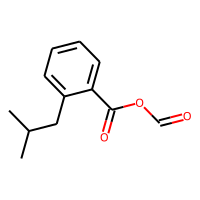
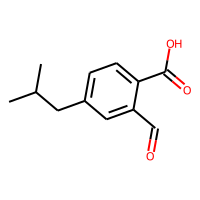
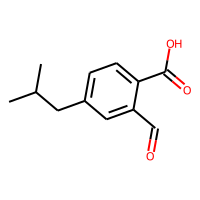
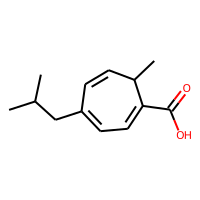
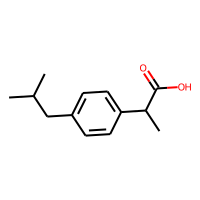

In [10]:
interp_df = pd.DataFrame({'interpolated_smiles': cddd_embeddings.inverse_transform(interp_embeddings)})
PandasTools.AddMoleculeColumnToFrame(interp_df, smilesCol='interpolated_smiles', molCol='interpolated_molecule')
interp_df

# Example 2: Acyclovir --> Remdesivir

Anti-virals for the next interpolation.

,name,transformed_smiles,transformed_molecule
0,acyclovir,C1=NC2=C(N1COCCO)N=C(NC2=O)N,
1,remdesivir,CCC(CC)COC(=O)C(C)NP(=O)(OCC1C(C(C(O1)(C#N)C2=...,

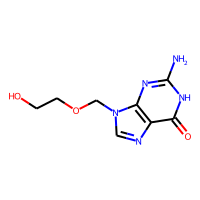
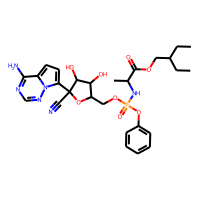

In [11]:
antiviral_data = pd.DataFrame({'name': ['acyclovir', 'remdesivir'], 
                     'transformed_smiles': ['C1=NC2=C(N1COCCO)N=C(NC2=O)N', 
                                            'CCC(CC)COC(=O)C(C)NP(=O)(OCC1C(C(C(O1)(C#N)C2=CC=C3N2N=CN=C3N)O)O)OC4=CC=CC=C4']})

PandasTools.AddMoleculeColumnToFrame(antiviral_data, smilesCol='transformed_smiles', molCol='transformed_molecule')
antiviral_data

INFO:tensorflow:Restoring parameters from /workspace/cddd/default_model/model.ckpt
(20, 512)
INFO:tensorflow:Restoring parameters from /workspace/cddd/default_model/model.ckpt


,interpolated_smiles,interpolated_molecule
0,Nc1nc2c(ncn2COCCO)c(=O)[nH]1,
1,Nc1nc2c(ncn2COCCO)c(=O)[nH]1,
2,Nc1nc2c(ncn2COCCO)c(=O)n1CO,
3,Nc1nc2c(ncn2COCCOCCO)c(=O)[nH]1,
4,NC(=O)Nc1nc2c(ncn2COCCO)c(=O)[nH]1,
5,Nc1nc2c(ncn2COCCOCCO)c2c1C(=O)N2,
6,Nc1nc2c(ncn2C2OC(COCCO)C2CO)c(=O)[nH]1,
7,Nc1nc2c(ncn2C2OC(COCCO)C2CO)c(=O)[nH]1,
8,Nc1nc2c(ncn2C2OC(COCCO)C(O)C2CO)c(=O)[nH]1,
9,CC(CO)NC(=O)c1nc2c(n1COCCO)C(N)c1cccnc1-2,

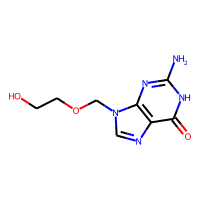
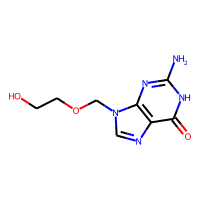
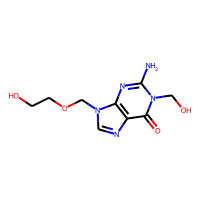
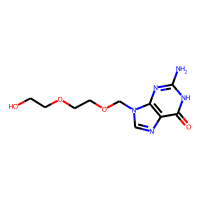
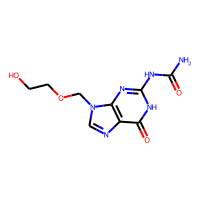
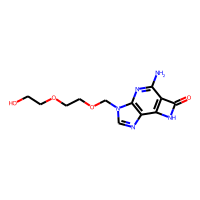
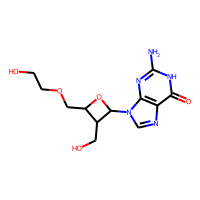
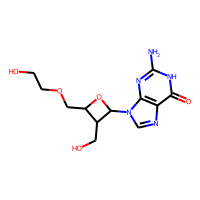
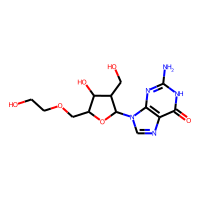
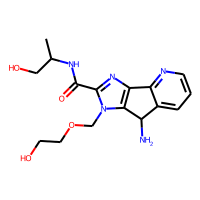
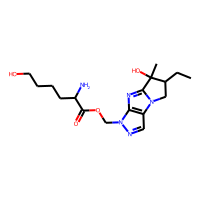
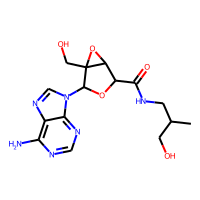
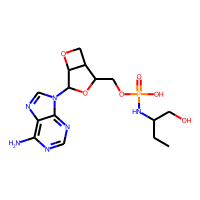
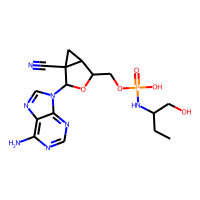
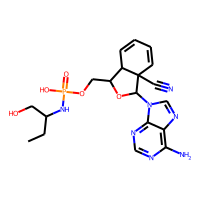
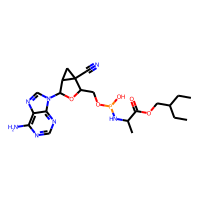
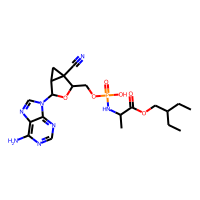
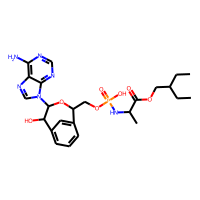
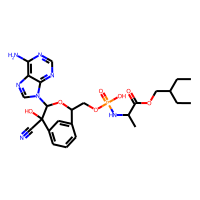
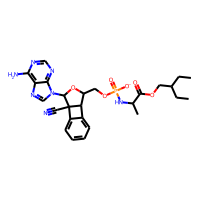

In [12]:
antiviral_embeddings = cddd_embeddings.transform(antiviral_data)
interp_antiviral_embeddings = np.apply_along_axis(linear_interpolate_points, axis=0, arr=antiviral_embeddings, num_points=20)
print(interp_antiviral_embeddings.shape)

interp_antiviral_df = pd.DataFrame({'interpolated_smiles': cddd_embeddings.inverse_transform(interp_antiviral_embeddings)})
PandasTools.AddMoleculeColumnToFrame(interp_antiviral_df, smilesCol='interpolated_smiles', molCol='interpolated_molecule')
interp_antiviral_df